<a href="https://colab.research.google.com/github/Spencer166/Capstone/blob/main/Step_8_Scale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 8: Scale Your ML Prototype

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

**Data:** I began by loading the data into a dataframe. The dataset that I used for this model is a random sample of 100,000 rows from a much larger dataset.

**Updates from previous step:** In order to scale this model to accomodate the extra data, I had to make the below modifications to keep a resonable runtime:


1.   **Used Less Features:** The dataset I used for this step had less features than the dataset I used in the previous step (12 vs 21). The features that were left out were numeric features that had little to no correlation with the target and/or were highly collinear with other features that were kept for this analysis. This was all discovered during my EDA in Step 5. Omitting these features speeds up the runtime but potentially reduces the score.
2.   **Used Only One Model:** In step 7 I tested three different classifiers (Logistic Regression, Random Forrest, Gradient Boosting) and used a Gridsearch on all three. For this step I only used Gradient Boosting because that was the best performing model in the previous step. I did still use a Gridsearch to test different hyperparameters on this larger dataset. While removing the other two classifiers speeds up the runtime, it does have the downside of not being able to test them on this new dataset.



In [5]:
# Path to the dataset
file_path = "/content/drive/MyDrive/train.csv"

# Load into DataFrame
df_full = pd.read_csv(file_path)

# Sample 100,000 rows
df = df_full.sample(n=100000, random_state=1)

# Display first few rows
print(df.shape)
df.head()

(100000, 13)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
566215,566215,52233.83,0.125,663,7454.22,14.89,Female,Married,PhD,Employed,Education,D2,1.0
123502,123502,29247.24,0.127,639,20391.28,12.29,Male,Married,High School,Unemployed,Debt consolidation,D2,0.0
367747,367747,13802.88,0.164,736,17984.01,11.00,Male,Single,Bachelor's,Self-employed,Home,C5,1.0
359153,359153,48758.31,0.090,707,10209.48,10.17,Female,Married,Bachelor's,Employed,Debt consolidation,C2,1.0
440880,440880,49816.42,0.090,665,18123.14,16.06,Male,Single,High School,Employed,Debt consolidation,D4,1.0


In [6]:
# Define Target
target = "loan_paid_back"

# Split into features and Target
X = df.drop(columns=[target])
y = df[target]

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

# Separate numeric and categorical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns


# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop="first",handle_unknown='ignore'), cat_cols)])

In [8]:
# Create pipeline with Gradient Boosting Classifier
pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))])

# Define models and parameter grids
param_grid = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 4]}

# Create a grid search object
gs = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=2)

# Fit to the training data
gs.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object'))])),
                                       ('model',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [3, 4],
                         'model__n_estimators': [100, 200]},
             scoring='roc_auc', verbose=2)

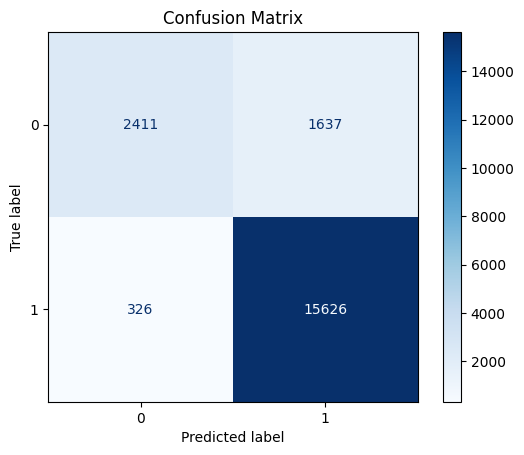

Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 200}
ROC-AUC: 0.9149465286918067
Accuracy: 0.90185

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.60      0.71      4048
         1.0       0.91      0.98      0.94     15952

    accuracy                           0.90     20000
   macro avg       0.89      0.79      0.83     20000
weighted avg       0.90      0.90      0.89     20000



In [13]:
#Define best model
best_model = gs.best_estimator_

# Define predictions and probabilities
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)


# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Define metrics
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

# Print metrics
print("Best parameters:", gs.best_params_)
print("ROC-AUC:", roc)
print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

**Conclusion:** Before completing this Step, I was expecting this model to be slighly less successful over the model in step 7 due to the reduction in features. However, this model actual outperformed the previous model in ROC-AUC but was slightly less accurate:

**Step 7 ROC-AUC:** 0.9033     
**Step 8 ROC-AUC:** 0.9149    

**Step 7 Accuracy:** 0.9022    
**Step 8 Accuracy:** 0.9018